In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import *
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback

import os, gc, time, argparse, json
import math, random, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import *

In [2]:
class CrossEntropyLoss(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target, reduction="mean"):
        N, C = input.size()

        if target.dim() > 1:
            one_hot = target
        else:
            one_hot = torch.zeros((N, C), dtype=input.dtype, device=input.device)
            one_hot.scatter_(1, target.reshape(N, 1), 1)

        loss = -(one_hot * F.log_softmax(input, 1)).sum(1)
        if reduction == "mean":
            return loss.mean(0)
        elif reduction == "sum":
            return loss.sum(0)
        else:
            return loss


class ClassificationMetric(object):
    def __init__(self, accuracy=True, recall=True, precision=True, f1=True, average="macro"):
        self.accuracy = accuracy
        self.recall = recall
        self.precision = precision
        self.f1 = f1
        self.average = average

        self.preds = []
        self.target = []

    def reset(self):
        self.preds.clear()
        self.target.clear()
        gc.collect()

    def update(self, preds, target):
        preds = list(preds.cpu().detach().argmax(1).numpy())
        target = list(target.cpu().detach().argmax(1).numpy()) if target.dim() > 1 else list(target.cpu().detach().numpy())
        self.preds += preds
        self.target += target

    def compute(self):
        metrics = []
        if self.accuracy:
            metrics.append(accuracy_score(self.target, self.preds))
        if self.recall:
            metrics.append(recall_score(self.target, self.preds, labels=list(set(self.preds)), average=self.average))
        if self.precision:
            metrics.append(precision_score(self.target, self.preds, labels=list(set(self.preds)), average=self.average))
        if self.f1:
            metrics.append(f1_score(self.target, self.preds, labels=list(set(self.preds)), average=self.average))
        self.reset()
        return metrics

In [3]:
class FlexibleTqdm(Callback):
    def __init__(self, steps, column_width=10):
        super(FlexibleTqdm, self).__init__()
        self.steps = steps
        self.column_width = column_width
        self.info = "\rEpoch_%d %s%% [%s]"

    def on_train_start(self, trainer, module):
        history = module.history
        self.row = "-" * (self.column_width + 1) * (len(history) + 2) + "-"
        title = "|"
        title += "epoch".center(self.column_width) + "|"
        title += "time".center(self.column_width) + "|"
        for i in history.keys():
            title += i.center(self.column_width) + "|"
        print(self.row)
        print(title)
        print(self.row)

    def on_train_batch_end(self, trainer, module, outputs, batch, batch_idx, dataloader_idx):
        current_index = int((batch_idx + 1) * 100 / self.steps)
        tqdm = ["."] * 100
        for i in range(current_index - 1):
            tqdm[i] = "="
        if current_index:
            tqdm[current_index - 1] = ">"
        print(self.info % (module.current_epoch, str(current_index).rjust(3), "".join(tqdm)), end="")

    def on_epoch_start(self, trainer, module):
        print(self.info % (module.current_epoch, "  0", "." * 100), end="")
        self.begin = time.perf_counter()

    def on_epoch_end(self, trainer, module):
        self.end = time.perf_counter()
        history = module.history
        detail = "\r|"
        detail += str(module.current_epoch).center(self.column_width) + "|"
        detail += ("%d" % (self.end - self.begin)).center(self.column_width) + "|"
        for j in history.values():
            detail += ("%.06f" % j[-1]).center(self.column_width) + "|"
        print("\r" + " " * 120, end="")
        print(detail)
        print(self.row)
        
        
class LearningCurve(Callback):
    def __init__(self, figsize=(12, 4), names=("loss", "acc", "f1")):
        super(LearningCurve, self).__init__()
        self.figsize = figsize
        self.names = names

    def on_fit_end(self, trainer, module):
        history = module.history
        plt.figure(figsize=self.figsize)
        for i, j in enumerate(self.names):
            plt.subplot(1, len(self.names), i + 1)
            plt.title(j + "/val_" + j)
            plt.plot(history[j], "--o", color='r', label=j)
            plt.plot(history["val_" + j], "-*", color='g', label="val_" + j)
            plt.legend()
        plt.show()

In [4]:
epochs = 10
batch_size = 128

In [5]:
train_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])
val_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
train_dataset = datasets.MNIST("data", train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataset = datasets.MNIST("data", train=False, transform=val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
class CustomModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 10, 5)
        self.conv2 = Conv2d(10, 20, 3)
        self.fc1 = Linear(20*10*10, 500)
        self.fc2 = Linear(500, 10)
        
        self.train_criterion = CrossEntropyLoss()
        self.val_criterion = CrossEntropyLoss()

        self.train_metric = ClassificationMetric(recall=False, precision=False)
        self.val_metric = ClassificationMetric(recall=False, precision=False)

        self.history = {
            "loss": [], "acc": [], "f1": [],
            "val_loss": [], "val_acc": [], "val_f1": [],
        }
        
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)
        out = self.conv2(out)
        out = F.relu(out)
        out = out.view(in_size, -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out
    
    def training_step(self, batch, idx):
        x, y = batch
        _y = self(x)
        loss = self.train_criterion(_y, y)
        self.train_metric.update(_y, y)
        return loss

    def training_epoch_end(self, outs):
        loss = 0.
        for out in outs:
            loss += out["loss"].cpu().detach().item()
        loss /= len(outs)
        acc, f1 = self.train_metric.compute()

        self.history["loss"].append(loss)
        self.history["acc"].append(acc)
        self.history["f1"].append(f1)

    def validation_step(self, batch, idx):
        x, y = batch
        _y = self(x)
        val_loss = self.val_criterion(_y, y)
        self.val_metric.update(_y, y)
        return val_loss

    def validation_epoch_end(self, outs):
        val_loss = sum(outs).item() / len(outs)
        val_acc, val_f1 = self.val_metric.compute()

        self.history["val_loss"].append(val_loss)
        self.history["val_acc"].append(val_acc)
        self.history["val_f1"].append(val_f1)

    def configure_optimizers(self):
        return Adam(self.parameters())

In [8]:
model = CustomModel()

In [9]:
trainer_params = {
    "gpus": 1,
    "max_epochs": epochs,  # 1000
    "checkpoint_callback": False,  # True
    "logger": False,  # TensorBoardLogger
    "progress_bar_refresh_rate": 0,  # 1
    "num_sanity_val_steps": 0,  # 2
    "callbacks": [
        FlexibleTqdm(len(train_dataset) // batch_size, column_width=12),
        LearningCurve(figsize=(12, 4), names=("loss", "acc", "f1")),
    ],  # None
}
trainer = pl.Trainer(**trainer_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name            | Type             | Params
-----------------------------------------------------
0 | conv1           | Conv2d           | 260   
1 | conv2           | Conv2d           | 1.8 K 
2 | fc1             | Linear           | 1.0 M 
3 | fc2             | Linear           | 5.0 K 
4 | train_criterion | CrossEntropyLoss | 0     
5 | val_criterion   | CrossEntropyLoss | 0     


---------------------------------------------------------------------------------------------------------
|   epoch    |    time    |    loss    |    acc     |     f1     |  val_loss  |  val_acc   |   val_f1   |
---------------------------------------------------------------------------------------------------------
|     0      |     7      |  0.185612  |  0.944383  |  0.943983  |  0.060953  |  0.980000  |  0.980004  |               
---------------------------------------------------------------------------------------------------------
|     1      |     7      |  0.052078  |  0.984217  |  0.984119  |  0.038682  |  0.986900  |  0.986838  |               
---------------------------------------------------------------------------------------------------------
|     2      |     7      |  0.033784  |  0.989483  |  0.989413  |  0.033859  |  0.987900  |  0.987861  |               
---------------------------------------------------------------------------------------------------------
|

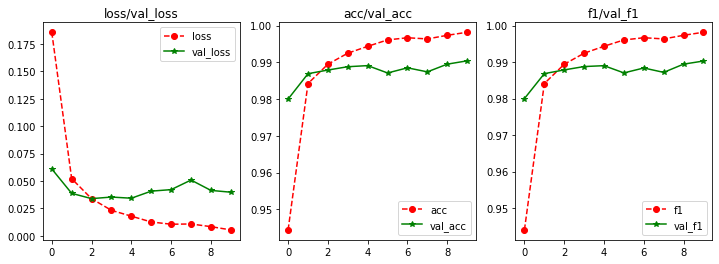

1

In [10]:
trainer.fit(model, train_dataloader, val_dataloader)